In [22]:
from typing import Dict
from cfgnet.network.network_configuration import NetworkConfiguration
from cfgnet.network.nodes import ArtifactNode
from cfgnet.network.network import Network
from pprint import pprint
from tqdm import tqdm
import git
import json
import subprocess
import traceback
import glob
import time

def checkout_latest_commit(repo, current_branch, latest_commit):
     # Return to the latest commit
    if current_branch:
        # If we were on a branch, return to it
        repo.git.checkout(current_branch)
        print(f"Returned to original branch: {current_branch}")
    else:
        # If we were in a detached HEAD state, checkout the latest commit directly
        repo.git.checkout(latest_commit)
        print(f"Returned to the latest commit: {latest_commit}")


def analyze_config_network(repo_path: str):
    
    network_config = NetworkConfiguration(
        project_root_abs=repo_path,
        enable_static_blacklist=False,
        enable_internal_links=True,
        enable_all_conflicts=True,
        enable_file_type_plugins=True,
        system_level=False
    )

    network = Network.init_network(cfg=network_config)

    artifacts = network.get_nodes(node_type=ArtifactNode)

    config_files_data = []
    for artifact in artifacts:
        pairs = artifact.get_pairs()
        config_files_data.append({
            "file_path": artifact.rel_file_path,
            "concept": artifact.concept_name,
            "options": len(artifact.get_pairs()),
            "pairs": pairs
        })


    config_files = set(artifact.rel_file_path for artifact in artifacts)
    concepts = set(artifact.concept_name for artifact in artifacts)
  	
    network_data = {
        "links": len(network.links),
        "config_files": list(config_files),
        "config_files_data": config_files_data
    }

    return network_data


def get_file_diff(repo_path: str, commit, file_path: str):
    if commit.parents:
        parent_commit = f"{commit.hexsha}^"
            
        try:                        
            # Run git diff to capture line-by-line changes
            diff_output = subprocess.check_output(
                ['git', 'diff', parent_commit, commit.hexsha, '--', file_path],
                cwd=repo_path,
                text=True
            )
            return diff_output
        except (subprocess.CalledProcessError, git.exc.GitCommandError) as e:
            print(f"Error running git diff for commit {commit.hexsha}: {e}")
            return None


def analyze_repository(repo_path: str, get_diff: bool = False) -> Dict:
    """Analyze Commit history of repositories and collect stats about the configuration space."""   
    repo = git.Repo(repo_path)

    # Save the current branch to return to it later
    current_branch = repo.active_branch.name if not repo.head.is_detached else None
    latest_commit = repo.head.commit.hexsha
    parent_commit = None

    # Get all commits in the repository from oldest to newest
    commits = list(repo.iter_commits("HEAD"))[::-1] 

    print(f"Number of commits: {len(commits)}")

    commit_data = []

    for commit in tqdm(commits, desc="Processing", total=len(commits)):

        is_config_related = False

        # Get commit stats
        stats = commit.stats.total

        # Checkout the commit
        repo.git.checkout(commit.hexsha)

        # Run the external analysis
        try: 
            network_data = analyze_config_network(repo_path=repo_path)
        except Exception:
            print(f"Error occurred in commit {commit.hexsha}")
            print({traceback.print_exc()})
            return

        # check if commit is config-related
        if any(file_path in network_data["config_files"] for file_path in commit.stats.files.keys()):
            is_config_related = True
            
            # Get general stats per config file
            for file_path, file_stats in commit.stats.files.items():
                
                # Get config file data
                if file_path in network_data["config_files"]:
                    file_data = next(filter(lambda x: x["file_path"] == file_path, network_data["config_files_data"]))
                    file_data["insertions"] = file_stats['insertions']
                    file_data["deletions"] = file_stats['deletions']
                    file_data["total_changes"] = file_stats['insertions'] + file_stats['deletions']

                    # Get config file diff
                    if get_diff:
                        diff_output = get_file_diff(
                            repo_path=repo_path,
                            commit=commit,
                            file_path=file_path
                        )

                        file_data["diff"] = diff_output

            # only add config data for config-related commits
            commit_data.append(
                {   
                    "commit_hash": str(commit.hexsha),
                    "parent_commit": (parent_commit),
                    "is_config_related": is_config_related,
                    "author": f"{commit.author.name} <{commit.author.email}>",
                    "commit_mgs": str(commit.message),
                    "files_changed": stats['files'],
                    "insertions": stats['insertions'],
                    "deletions": stats['deletions'],
                    "network_data": network_data
                }
            )

    # Return to latest commit
    checkout_latest_commit(
        repo=repo, 
        current_branch=current_branch,
        latest_commit=latest_commit
    )

    print(f"Len commit data: {len(commit_data)}, {round(len(commit_data)/len(commits), 2)}")
    
    return commit_data


project_dir = "/home/simisimon/GitHub/cfgnet_evaluation"
execution_stats = []

for project_path in glob.glob(project_dir + "/**"):
    project_name = project_path.split("/")[-1]
    
    print(f"Analyze {project_name}")

    start_time = time.time()

    commit_data = analyze_repository(repo_path=project_path, get_diff=True)

    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.6f} seconds")

    execution_stats.append({"project_name": project_name, "analysis_time": elapsed_time})

    output_file = f"../data/analyzed_projects/{project_name}.json"

    print(f"Write commit data into file {output_file}")
    with open(output_file, "w", encoding="utf-8") as dest:
        json.dump(commit_data, dest, indent=2)

with open("../data/execuation_stats.json", "w", encoding="utf-8") as dest:
    json.dump(execution_stats, dest, indent=2)


#test_repo_path = "/home/simisimon/GitHub/cfgnet_evaluation/netflix-oss-example"
#test_repo_path = "/home/simisimon/GitHub/projects/test_project_history"
#analyze_repository(repo_path=test_repo_path, branch_name="master", get_diff=True)

Analyze mentorship-platform
Number of commits: 100


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing: 100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


Returned to the latest commit: baf399c02cd96f113ed71508194231bb0349f7d1
Len commit data: 22, 0.22
Elapsed time: 9.211015 seconds
Write commit data into file ../data/analyzed_projects/mentorship-platform.json
Analyze netflix-oss-example
Number of commits: 121


Processing:  98%|█████████▊| 118/121 [00:15<00:00,  7.03it/s]WARNING:root:Failed to parse yml file "spring-cloud-dashboard/src/main/resources/application.yml"" with spring parser due to "expected a single document in the stream
  in "/home/simisimon/GitHub/cfgnet_evaluation/netflix-oss-example/spring-cloud-dashboard/src/main/resources/application.yml", line 1, column 1
but found another document
  in "/home/simisimon/GitHub/cfgnet_evaluation/netflix-oss-example/spring-cloud-dashboard/src/main/resources/application.yml", line 9, column 1"
Processing:  98%|█████████▊| 119/121 [00:15<00:00,  4.22it/s]WARNING:root:Failed to parse yml file "spring-cloud-dashboard/src/main/resources/application.yml"" with spring parser due to "expected a single document in the stream
  in "/home/simisimon/GitHub/cfgnet_evaluation/netflix-oss-example/spring-cloud-dashboard/src/main/resources/application.yml", line 1, column 1
but found another document
  in "/home/simisimon/GitHub/cfgnet_evaluation/netflix-os

Returned to original branch: master
Len commit data: 47, 0.39
Elapsed time: 16.322497 seconds
Write commit data into file ../data/analyzed_projects/netflix-oss-example.json
Analyze piggymetrics
Number of commits: 288


Processing: 100%|██████████| 288/288 [00:59<00:00,  4.84it/s]


Returned to original branch: master
Len commit data: 125, 0.43
Elapsed time: 59.513717 seconds
Write commit data into file ../data/analyzed_projects/piggymetrics.json
Analyze spring-boot-blog
Number of commits: 34


Processing: 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]


Returned to original branch: master
Len commit data: 4, 0.12
Elapsed time: 3.513315 seconds
Write commit data into file ../data/analyzed_projects/spring-boot-blog.json
Analyze taskManagement
Number of commits: 88


Processing: 100%|██████████| 88/88 [00:07<00:00, 11.05it/s]


Returned to original branch: development
Len commit data: 16, 0.18
Elapsed time: 8.004231 seconds
Write commit data into file ../data/analyzed_projects/taskManagement.json
Analyze Ward
Number of commits: 302


Processing: 100%|██████████| 302/302 [00:27<00:00, 10.84it/s]

Returned to original branch: master
Len commit data: 94, 0.31
Elapsed time: 27.895897 seconds
Write commit data into file ../data/analyzed_projects/Ward.json


**Evolution of the confguration space of open-source software projects**

- statistics:
    - growth of config files
    - change frequency of config files
    - distribution of config-related and non-config-related commit
    - distribution of contributors that perform config changes
    - total number of options over time
    - total number of links over time

/home/simisimon/GitHub/config-space/env/lib/python3.11/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


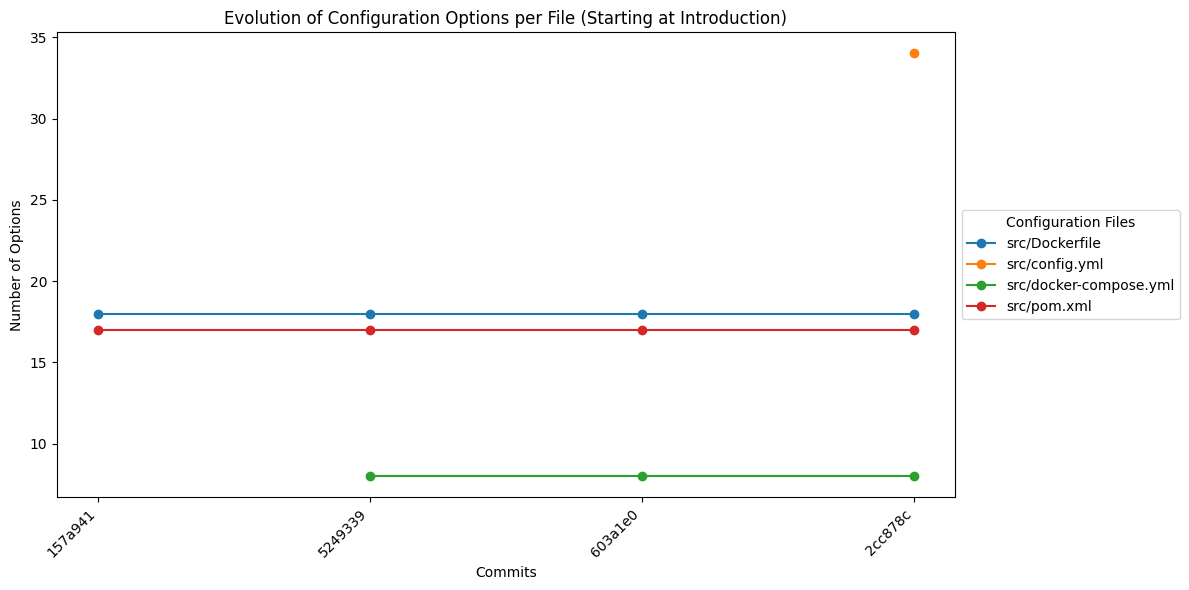

In [3]:
import matplotlib.pyplot as plt
import json

# data_file = "../data/analyzed_projects/netflix-oss-example.json"
data_file = "../data/analyzed_projects/test_project_history.json"

with open(data_file, "r", encoding="utf-8") as src:
    data = json.load(src)

# Extract data for plotting
files = set()
file_data = {}

for commit in data:
    commit_hash = commit["commit_hash"]
    for config_file in commit["network_data"]["config_files_data"]:
        file_path = config_file["file_path"]
        options = config_file["options"]
        files.add(file_path)
        if file_path not in file_data:
            file_data[file_path] = []
        file_data[file_path].append((commit_hash, options))

# Prepare data for plotting
x_ticks = [commit["commit_hash"] for commit in data]

# Adjust the plotting logic to start the line at the introduction commit
file_lines = {file: [None] * len(x_ticks) for file in files}

for file, changes in file_data.items():
    for commit_hash, options in changes:
        index = x_ticks.index(commit_hash)
        file_lines[file][index] = options

# Replace None with previous values for continuity
for file, options in file_lines.items():
    last_value = None
    for i in range(len(options)):
        if options[i] is None:
            options[i] = last_value
        else:
            last_value = options[i]

shortened_x_ticks = [commit[:7] for commit in x_ticks]

# Re-plot with shortened commit hashes
plt.figure(figsize=(12, 6))
for file, options in file_lines.items():
    plt.plot(shortened_x_ticks, options, marker="o", label=file)

plt.xlabel("Commits")
plt.ylabel("Number of Options")
plt.title("Evolution of Configuration Options per File (Starting at Introduction)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Configuration Files", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

**Evolution of the configuration options**


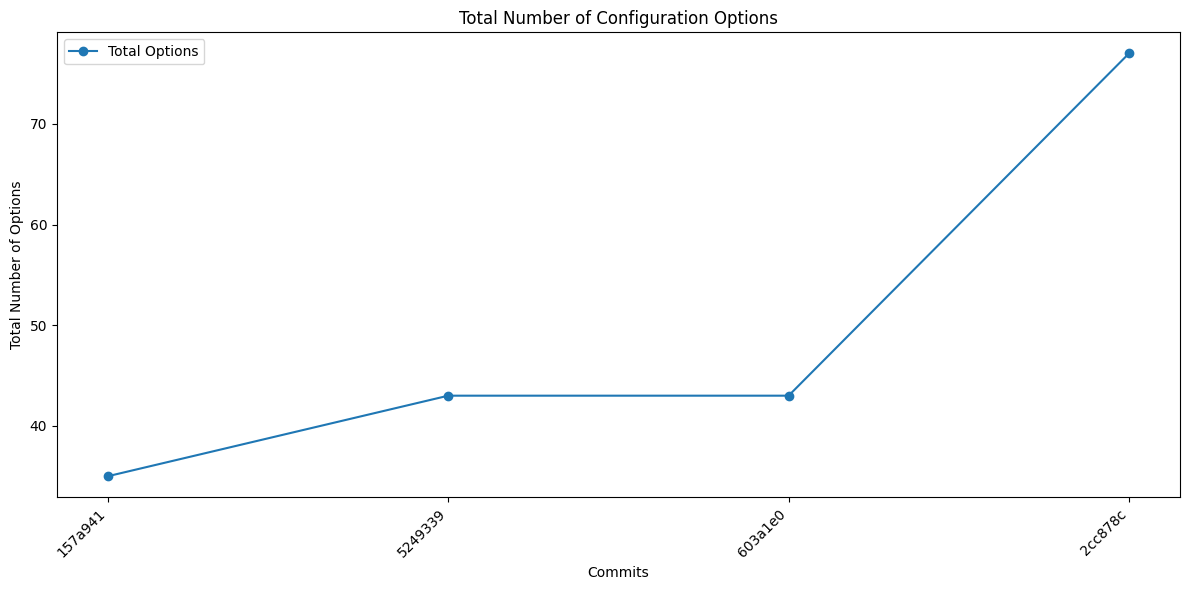

In [4]:
import matplotlib.pyplot as plt

# Extract data for plotting
files = set()
file_data = {}

for commit in data:
    commit_hash = commit["commit_hash"]
    for config_file in commit["network_data"]["config_files_data"]:
        file_path = config_file["file_path"]
        options = config_file["options"]
        files.add(file_path)
        if file_path not in file_data:
            file_data[file_path] = []
        file_data[file_path].append((commit_hash, options))

# Prepare data for plotting
x_ticks = [commit["commit_hash"] for commit in data]

# Adjust the plotting logic to start the line at the introduction commit
file_lines = {file: [None] * len(x_ticks) for file in files}

for file, changes in file_data.items():
    for commit_hash, options in changes:
        index = x_ticks.index(commit_hash)
        file_lines[file][index] = options

# Calculate the total number of options across all configuration files per commit
total_options_per_commit = [0] * len(x_ticks)

for file, options in file_lines.items():
    for i, option_count in enumerate(options):
        if option_count is not None:
            total_options_per_commit[i] += option_count

# Plot the total number of options over time
plt.figure(figsize=(12, 6))
plt.plot(shortened_x_ticks, total_options_per_commit, marker="o", label="Total Options")

plt.xlabel("Commits")
plt.ylabel("Total Number of Options")
plt.title("Total Number of Configuration Options")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

**Evolution of links**

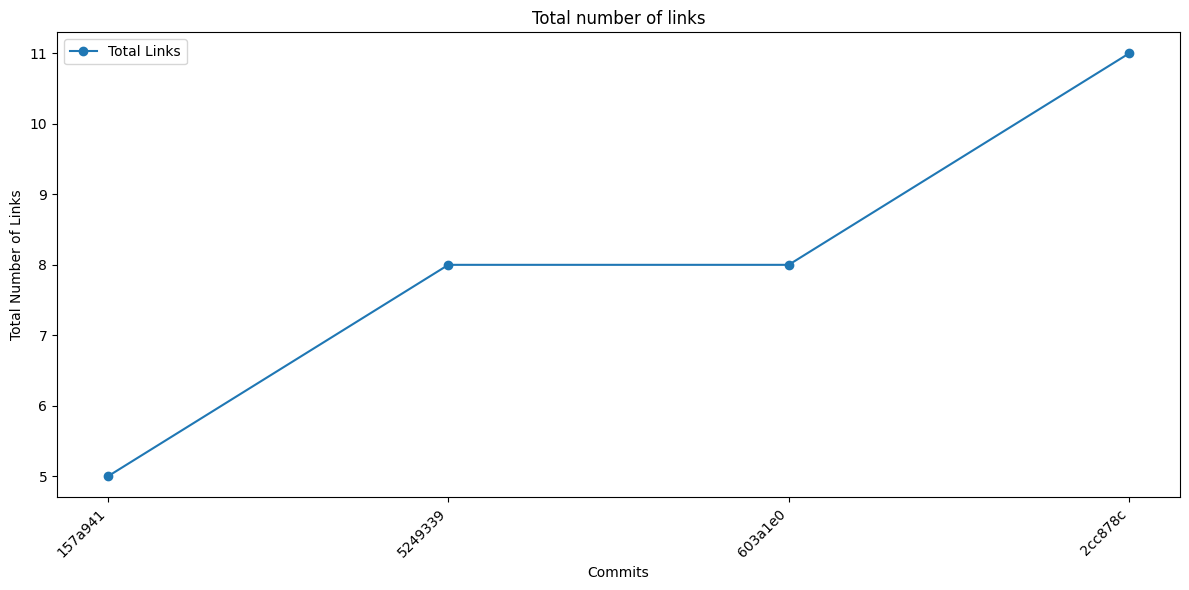

In [5]:
# Extract the total number of links per commit
total_links_per_commit = [commit["network_data"]["links"] for commit in data]

# Shorten commit hashes for x-axis
shortened_x_ticks = [commit["commit_hash"][:7] for commit in data]

# Plot the total number of links over time
plt.figure(figsize=(12, 6))
plt.plot(shortened_x_ticks, total_links_per_commit, marker="o", label="Total Links")

plt.xlabel("Commits")
plt.ylabel("Total Number of Links")
plt.title("Total number of links")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

**Distribution of config-related and non-config-related commits**

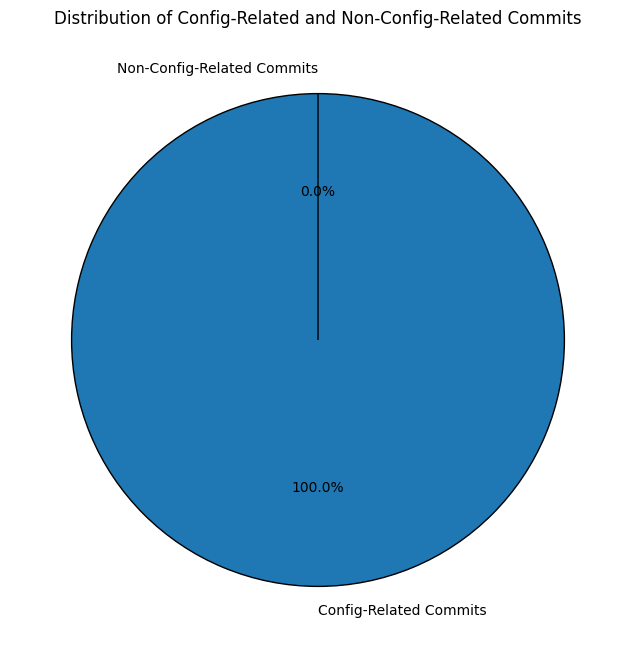

In [6]:
import matplotlib.pyplot as plt

config_related_count = 0
non_config_related_count = 0

for commit in data:
    config_files_changed = any(
        "insertions" in file or "deletions" in file
        for file in commit["network_data"]["config_files_data"]
    )
    if config_files_changed:
        config_related_count += 1
    else:
        non_config_related_count += 1

# Data for the pie chart
labels = ['Config-Related Commits', 'Non-Config-Related Commits']
sizes = [config_related_count, non_config_related_count]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
plt.title("Distribution of Config-Related and Non-Config-Related Commits")
plt.show()

**Frequency how often a specific config file has changed**

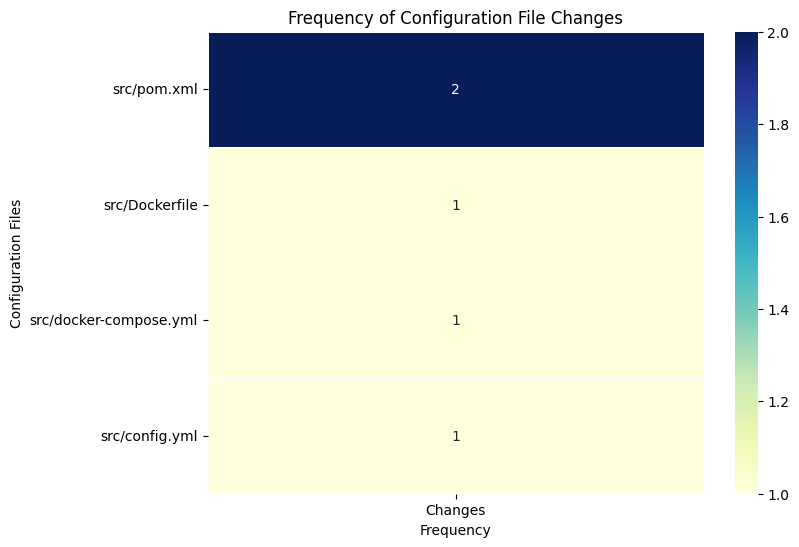

In [7]:
import seaborn as sns
import pandas as pd

# Count how often each configuration file has changed
file_change_counts = {}

for commit in data:
    for config_file in commit["network_data"]["config_files_data"]:
        file_path = config_file["file_path"]
        insertions = config_file.get("insertions", 0)
        deletions = config_file.get("deletions", 0)
        if insertions > 0 or deletions > 0:
            file_change_counts[file_path] = file_change_counts.get(file_path, 0) + 1

# Convert data to a DataFrame for heatmap plotting
file_change_df = pd.DataFrame(list(file_change_counts.items()), columns=["File", "Changes"])
file_change_df = file_change_df.sort_values(by="Changes", ascending=False)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(file_change_df.set_index("File"), annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)

plt.title("Frequency of Configuration File Changes")
plt.xlabel("Frequency")
plt.ylabel("Configuration Files")
plt.show()

**Contributors of Configuration Changes**

- TODO: Try to extract what concepts are changed by a contributor.

In [8]:
# Initialize dictionaries to count changes for configuration-related and remaining changes
contributor_config_changes = {}
contributor_other_changes = {}

for commit in data:
    author = commit["author"]
    config_files_changed = any(
        "insertions" in file or "deletions" in file
        for file in commit["network_data"]["config_files_data"]
    )
    if author not in contributor_config_changes:
        contributor_config_changes[author] = 0
    if author not in contributor_other_changes:
        contributor_other_changes[author] = 0
    
    if config_files_changed:
        contributor_config_changes[author] += 1
    else:
        contributor_other_changes[author] += 1

# Combine results into a DataFrame
contributor_changes_combined_df = pd.DataFrame({
    "Contributor": contributor_config_changes.keys(),
    "Config Changes": contributor_config_changes.values(),
    "Other Changes": contributor_other_changes.values()
}).sort_values(by=["Config Changes", "Other Changes"], ascending=False)

contributor_changes_combined_df

,Contributor,Config Changes,Other Changes
0,Sebastian Simon <bastisimon95@googlemail.com>,4,0


**Taxonomy of configuration changes in X most popular open-source software projects**

- increase understading of configuration changes
    - which options change frequently?
    - what kind of options are added/removed?
    - why do these options change frequently? 